# Initialization



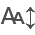

In [1]:
%load_ext autoreload
%autoreload 3

from collections.abc import Iterable
from datetime import datetime
from functools import partial

import contextily
import dask.dataframe as dd
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bdproject.aggregations import agg_tdigest
from bdproject.dataset_helpers import (
    COLOR_FHV,
    COLOR_FHVHV,
    COLOR_GREEN,
    COLOR_YELLOW,
    LABEL_HUMAN_READABLE_TO_COLOR,
    label_to_human_readable,
)
from bdproject.filters import (
    get_ddf_t1,
    get_ddf_universal,
)
from bdproject.local_cluster import local_cluster_start
from bdproject.notebook import disp, init, savefig
from bdproject.paths import get_path_t1
from bdproject.shapefile import get_gdf_shapefile
from bdproject.slurm_cluster import RUNNING_INSIDE_CLUSTER, slurm_cluster_start

init()

In [22]:
client = (
    slurm_cluster_start("8GiB", 8, 2)
    if RUNNING_INSIDE_CLUSTER
    else local_cluster_start("6GiB")
)

Dashboard at 153.5.72.15:8787


In [23]:
ddf_yellow_original = get_ddf_t1("yellow")
ddf_green_original = get_ddf_t1("green")
ddf_fhv_original = get_ddf_t1("fhv")
ddf_fhvhv_original = get_ddf_t1("fhvhv")

ddf_yellow = get_ddf_universal(ddf_yellow_original)
ddf_green = get_ddf_universal(ddf_green_original)
ddf_fhv = get_ddf_universal(ddf_fhv_original)
ddf_fhvhv = get_ddf_universal(ddf_fhvhv_original)

gdf_shapefile = get_gdf_shapefile()

# EDA


## Column statistics


In [4]:
def with_trip_time(ddf: dd.DataFrame):
    return ddf.assign(
        trip_time=lambda ddf: (ddf["do_dt"] - ddf["pu_dt"]).dt.total_seconds()
    )


def compute_colstats(ddf: dd.DataFrame, potential_cols: Iterable[str], label: str):
    cols = [col for col in potential_cols if col in ddf]
    return (
        ddf[cols]
        .melt(var_name="col", value_name="value")
        .groupby("col")
        .agg(
            mean=("value", "mean"),
            std=("value", "std"),
            min=("value", "min"),
            max=("value", "max"),
            n_all=("value", "size"),
            n_nonnull=("value", "count"),
            quantiles=("value", agg_tdigest(quantile=(0.25, 0.5, 0.75))),
        )
        .assign(
            frac_null=lambda ddf: 1 - (ddf["n_nonnull"] / ddf["n_all"]),
            q25=lambda ddf: ddf["quantiles"].str[0],
            q50=lambda ddf: ddf["quantiles"].str[1],
            q75=lambda ddf: ddf["quantiles"].str[2],
            iqr=lambda ddf: ddf["q75"] - ddf["q25"],
            dataset=label,
        )
        .drop(columns=["n_all", "n_nonnull", "quantiles"])
        .reset_index()
    )


cols = ["passengers", "distance", "trip_time", "fee_fare", "fee_tip", "fee_total"]
df_colstats = (
    dd.concat(
        [
            compute_colstats(with_trip_time(ddf_yellow), cols, "yellow"),
            compute_colstats(with_trip_time(ddf_green), cols, "green"),
            compute_colstats(with_trip_time(ddf_fhv), cols, "fhv"),
            compute_colstats(with_trip_time(ddf_fhvhv), cols, "fhvhv"),
        ],
    )
    .compute()
    .sort_values(["dataset", "col"])
    .set_index(["dataset", "col"])
)
df_colstats

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [5]:
df_colstats.xs("trip_time", level="col").apply(partial(pd.to_timedelta, unit="s"))

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


## Volume over time (monthly, raw)


In [6]:
def compute_volume(ddf: dd.DataFrame, label: str) -> dd.DataFrame:
    return (
        ddf.assign(month=ddf["pu_dt"].dt.to_period("M"))
        .groupby("month")
        .agg(volume=("month", "size"))
        .reset_index()
        .assign(label=label)
    )


df_volume_over_time_month_raw = (
    dd.concat(
        [
            compute_volume(ddf_yellow, "yellow"),
            compute_volume(ddf_green, "green"),
            compute_volume(ddf_fhv, "fhv"),
            compute_volume(ddf_fhvhv, "fhvhv"),
        ]
    )
    .sort_values(["month", "label"])
    .compute()
    .reset_index(drop=True)
)
df_volume_over_time_month_raw

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


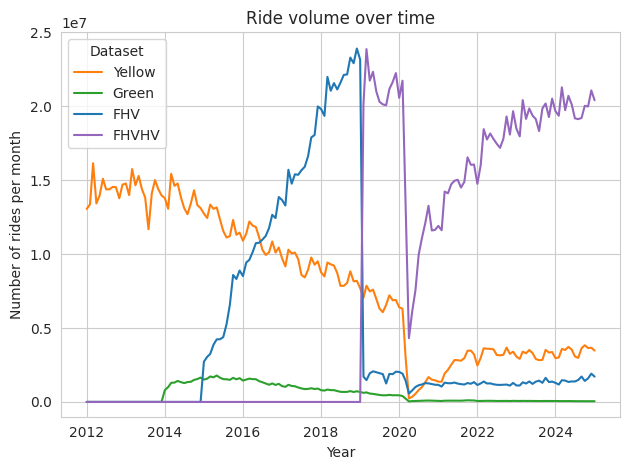

In [7]:
df = df_volume_over_time_month_raw.pivot(
    columns="label",
    index="month",
    values="volume",
).fillna(0)
dfi = df.index.to_timestamp()

fig, ax = plt.subplots()
ax.plot(dfi, df["yellow"], label="Yellow", color=COLOR_YELLOW)
ax.plot(dfi, df["green"], label="Green", color=COLOR_GREEN)
ax.plot(dfi, df["fhv"], label="FHV", color=COLOR_FHV)
ax.plot(dfi, df["fhvhv"], label="FHVHV", color=COLOR_FHVHV)

ax.set_ylim(-0.1e7, 2.5e7)

ax.set_title("Ride volume over time")
ax.set_xlabel("Year")
ax.set_ylabel("Number of rides per month")

ax.legend(title="Dataset")
fig.tight_layout()
savefig(fig, "fig/t4_volume_mixed_overall.pdf")

## FHV/FHVHV operator mapping


In [2]:
with duckdb.connect() as conn:
    conn.sql(f"CREATE VIEW fhv AS SELECT * FROM '{get_path_t1('fhv')}/**/*.parquet'")
    conn.sql(
        f"CREATE VIEW fhvhv AS SELECT * FROM '{get_path_t1('fhvhv')}/**/*.parquet'"
    )
    print("License numbers that show up in the FHVHV dataset:")
    disp(
        conn.sql(
            "SELECT hvfhs_license_num, COUNT(*) AS n FROM fhvhv "
            "GROUP BY hvfhs_license_num ORDER BY n DESC"
        ).to_df()
    )
    print("Base numbers in the FHV dataset that stop showing up after 2019-01-31:")
    df_suspected_hv = conn.sql(
        "WITH dispatches AS (SELECT UPPER(dispatching_base_num) AS dbn, pickup_datetime AS pu_dt FROM fhv WHERE dbn IS NOT NULL),"
        "lastseen AS (SELECT dbn, MAX(pu_dt) AS ls FROM dispatches GROUP BY dbn)"
        "SELECT dbn, ls FROM lastseen WHERE date_trunc('day', ls) == '2019-01-31'"
    ).to_df()
    disp(df_suspected_hv)
    print("Base numbers that show up in the FHVHV dataset:")
    df_exists_in_fhvhv = conn.sql(
        "SELECT DISTINCT UPPER(dispatching_base_num) AS dbn, hvfhs_license_num AS ln "
        "FROM fhvhv WHERE dbn <> 'NULL'"
    ).to_df()
    disp(df_exists_in_fhvhv)

License numbers that show up in the FHVHV dataset:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Base numbers in the FHV dataset that stop showing up after 2019-01-31:


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Base numbers that show up in the FHVHV dataset:


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [25]:
print(
    "Base numbers in the FHVHV dataset that are used by multiple different license numbers:"
)
df_exists_in_fhvhv.groupby("dbn").agg(n=("dbn", "size")).loc[lambda df: df["n"] > 1]

Base numbers in the FHVHV dataset that are used by multiple different license numbers:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [26]:
df_fhv_breakdown = df_suspected_hv.merge(
    df_exists_in_fhvhv, how="outer", on="dbn", indicator=True
)
df_fhv_breakdown

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [27]:
big_hv_operators = {"HV0003", "HV0005"}

set_fhv_hvbig = frozenset(
    df_fhv_breakdown[
        lambda df: (df["_merge"] == "both") & df["ln"].isin(big_hv_operators)
    ]["dbn"]
)
set_fhv_hvsmall = frozenset(
    df_fhv_breakdown[
        lambda df: (df["_merge"] == "both") & ~df["ln"].isin(big_hv_operators)
    ]["dbn"]
)
set_fhv_hv = set_fhv_hvbig | set_fhv_hvsmall

print(
    "FHVHV base numbers in the FHV dataset: "
    f"{len(set_fhv_hvbig)} Uber/Lyft + {len(set_fhv_hvsmall)} other "
)


def classify_fhv(ddf: dd.DataFrame) -> dd.DataFrame:
    assert "licensenum" not in ddf
    return ddf.assign(label="fhv_small").assign(
        label=(
            lambda ddf: ddf["label"]
            .where(~ddf["dbasenum"].isin(set_fhv_hvbig), "fhv_big")
            .mask(ddf["dbasenum"].isna())
        )
    )


def classify_fhvhv(ddf: dd.DataFrame) -> dd.DataFrame:
    return ddf.assign(label="fhv_big").assign(
        label=(
            lambda ddf: ddf["label"]
            .where(ddf["licensenum"].isin(big_hv_operators), "fhv_small")
            .mask(ddf["licensenum"].isna())
        )
    )

FHVHV base numbers in the FHV dataset: 29 Uber/Lyft + 3 other 


## Volume over time (monthly)

Requires "FHV/FHVHV operator mapping"


In [8]:
df_volume_over_time_month = (
    dd.concat(
        [
            ddf_yellow.assign(label="yellow"),
            ddf_green.assign(label="green"),
            ddf_fhv.pipe(classify_fhv),
            ddf_fhvhv.pipe(classify_fhvhv),
        ]
    )
    .assign(month=lambda ddf: ddf["pu_dt"].dt.to_period("M"))
    .groupby(["month", "label"])
    .agg(volume=("month", "size"))
    .reset_index()
    .compute()
    .sort_values(["month", "label"], ignore_index=True)
)
df_volume_over_time_month

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


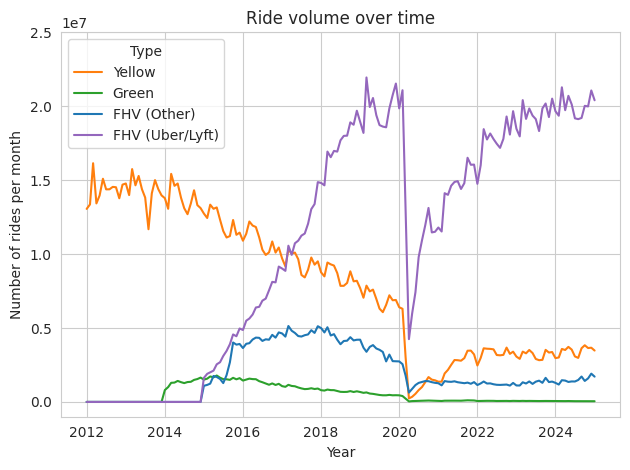

In [9]:
df = df_volume_over_time_month.pivot(
    columns="label",
    index="month",
    values="volume",
).fillna(0)
dfi = df.index.to_timestamp()

fig, ax = plt.subplots()
ax.plot(dfi, df["yellow"], label="Yellow", color=COLOR_YELLOW)
ax.plot(dfi, df["green"], label="Green", color=COLOR_GREEN)
ax.plot(dfi, df["fhv_small"], label="FHV (Other)", color=COLOR_FHV)
ax.plot(dfi, df["fhv_big"], label="FHV (Uber/Lyft)", color=COLOR_FHVHV)

ax.set_ylim(-0.1e7, 2.5e7)

ax.set_title("Ride volume over time")
ax.set_xlabel("Year")
ax.set_ylabel("Number of rides per month")

ax.legend(title="Type")
fig.tight_layout()
savefig(fig, "fig/t4_volume_overall.pdf")

## Volume over time (daily, weekly)

Requires "FHV/FHVHV operator mapping"


In [10]:
df_volume_over_time_hour = (
    dd.concat(
        [
            ddf_yellow.assign(label="yellow"),
            ddf_green.assign(label="green"),
            ddf_fhv.pipe(classify_fhv),
            ddf_fhvhv.pipe(classify_fhvhv),
        ],
    )
    .assign(hour=lambda ddf: ddf["pu_dt"].dt.to_period("h"))
    .groupby(["hour", "label"])
    .agg(volume=("hour", "size"))
    .reset_index()
    .compute()
    .sort_values(["hour", "label"], ignore_index=True)
)
df_volume_over_time_hour

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


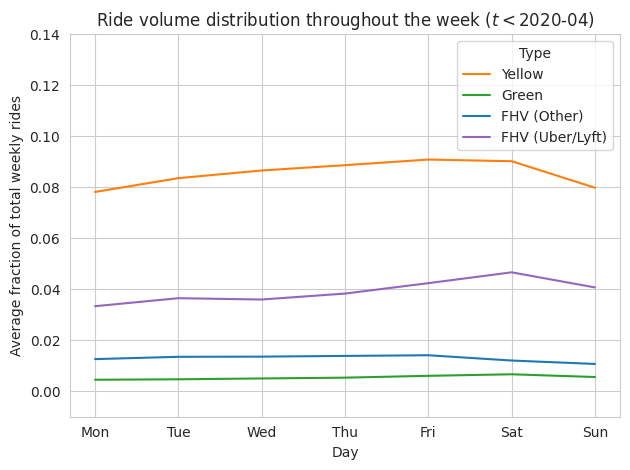

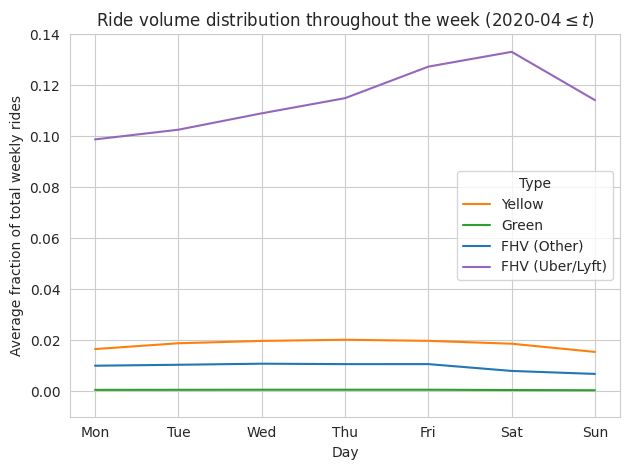

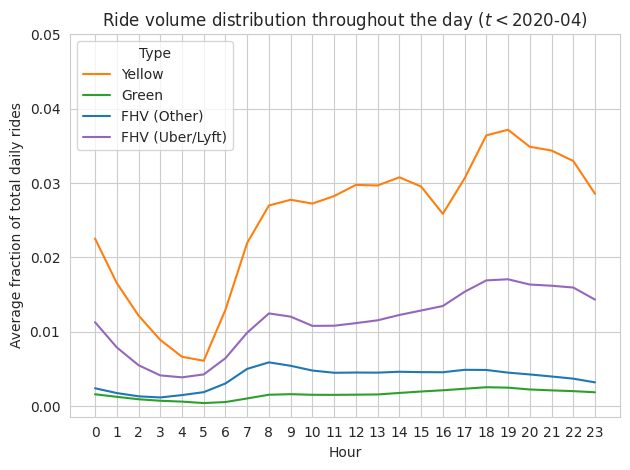

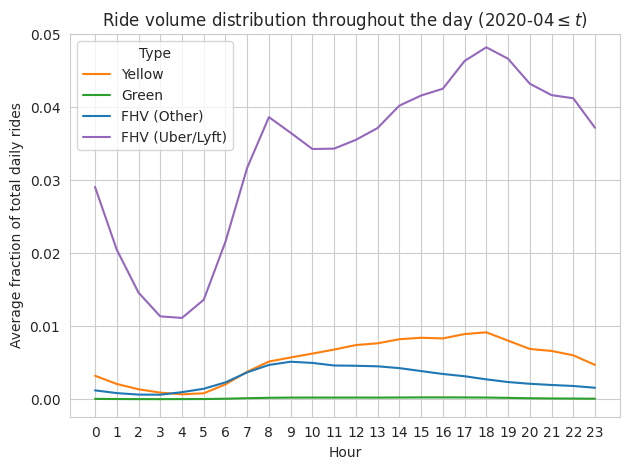

In [11]:
def compute_volume_aggregate_day(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.assign(
            day=lambda df: df["hour"].dt.asfreq("D"),
            daily_volume=lambda df: df.groupby("day")["volume"].transform("sum"),
            volume=lambda df: df["volume"] / df["daily_volume"],
            hour=lambda df: df["hour"].dt.hour,
            n_datapoints=lambda df: df["day"].nunique(),
        )[["hour", "label", "volume", "n_datapoints"]]
        .groupby(["hour", "label"])
        .agg(
            volume=("volume", "sum"),
            n_datapoints=("n_datapoints", "first"),
        )
        .assign(volume=lambda df: df["volume"] / df["n_datapoints"])
        .drop(columns="n_datapoints")
    )


def compute_volume_aggregate_week(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.assign(
            day=lambda df: df["hour"].dt.asfreq("D"),
        )
        .drop(columns="hour")
        .groupby(["day", "label"])
        .sum()
        .reset_index()
        .assign(
            week=lambda df: df["day"].dt.asfreq("W-MON"),
            weekly_volume=lambda df: df.groupby("week")["volume"].transform("sum"),
            volume=lambda df: df["volume"] / df["weekly_volume"],
            day=lambda df: df["day"].dt.weekday,
            n_datapoints=lambda df: df["week"].nunique(),
        )[["day", "label", "volume", "n_datapoints"]]
        .groupby(["day", "label"])
        .agg(
            volume=("volume", "sum"),
            n_datapoints=("n_datapoints", "first"),
        )
        .assign(volume=lambda df: df["volume"] / df["n_datapoints"])
        .drop(columns="n_datapoints")
    )


def plot_hour_distribution(filter, title_fragment: str, filename_fragment: str):
    df = (
        df_volume_over_time_hour.loc[filter]
        .pipe(compute_volume_aggregate_day)
        .reset_index()
        .pivot(
            columns="label",
            index="hour",
            values="volume",
        )
        .fillna(0)
    )

    fig, ax = plt.subplots()

    ax.plot(df.index, df["yellow"], label="Yellow", color=COLOR_YELLOW)
    ax.plot(df.index, df["green"], label="Green", color=COLOR_GREEN)
    ax.plot(df.index, df["fhv_small"], label="FHV (Other)", color=COLOR_FHV)
    ax.plot(df.index, df["fhv_big"], label="FHV (Uber/Lyft)", color=COLOR_FHVHV)

    ax.set_ylim(top=0.05)
    ax.set_xticks(df.index)

    ax.set_title(f"Ride volume distribution throughout the day ({title_fragment})")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Average fraction of total daily rides")

    ax.legend(title="Type")
    fig.tight_layout()
    savefig(fig, f"fig/t4_volume_daily_{filename_fragment}.pdf")


def plot_day_distribution(filter, title_fragment: str, filename_fragment: str):
    df = (
        df_volume_over_time_hour.loc[filter]
        .pipe(compute_volume_aggregate_week)
        .reset_index()
        .sort_values("day", ignore_index=True)
        .pivot(
            columns="label",
            index="day",
            values="volume",
        )
        .fillna(0)
    )

    fig, ax = plt.subplots()

    ax.plot(df.index, df["yellow"], label="Yellow", color=COLOR_YELLOW)
    ax.plot(df.index, df["green"], label="Green", color=COLOR_GREEN)
    ax.plot(df.index, df["fhv_small"], label="FHV (Other)", color=COLOR_FHV)
    ax.plot(df.index, df["fhv_big"], label="FHV (Uber/Lyft)", color=COLOR_FHVHV)

    ax.set_ylim(-0.01, 0.14)
    ax.set_xticks(
        df.index,
        df.index.map(
            {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
        ),
    )

    ax.set_title(f"Ride volume distribution throughout the week ({title_fragment})")
    ax.set_xlabel("Day")
    ax.set_ylabel("Average fraction of total weekly rides")

    ax.legend(title="Type")
    fig.tight_layout()
    savefig(fig, f"fig/t4_volume_weekly_{filename_fragment}.pdf")


def filter_pre2020(df: pd.DataFrame):
    return df["hour"].dt.to_timestamp() < datetime(2020, 4, 1)


def filter_post2020(df: pd.DataFrame):
    return datetime(2020, 4, 1) <= df["hour"].dt.to_timestamp()


plot_day_distribution(filter_pre2020, "$t < \\text{2020-04}$", "pre2020")
plot_day_distribution(filter_post2020, "$\\text{2020-04} \\leq t$", "post2020")
plot_hour_distribution(filter_pre2020, "$t < \\text{2020-04}$", "pre2020")
plot_hour_distribution(filter_post2020, "$\\text{2020-04} \\leq t$", "post2020")

## Volume over taxi zones

Requires "FHV/FHVHV operator mapping"


In [12]:
df_volume_over_zones = (
    dd.concat(
        [
            ddf_yellow.assign(label="yellow"),
            ddf_green.assign(label="green"),
            ddf_fhv.pipe(classify_fhv),
            ddf_fhvhv.pipe(classify_fhvhv),
        ]
    )
    .pipe(
        lambda ddf: dd.concat(
            [
                ddf.assign(locid=ddf["pu_locid"])[["locid", "label"]],
                ddf.assign(locid=ddf["do_locid"])[["locid", "label"]],
            ]
        )
    )
    .groupby(["locid", "label"])
    .agg(n=("locid", "size"))
    .reset_index()
    .compute()
    .sort_values("n", ascending=False, ignore_index=True)
)
df_volume_over_zones.merge(
    gdf_shapefile[["OBJECTID", "zone", "borough"]],
    how="left",
    left_on="locid",
    right_on="OBJECTID",
).drop(columns="OBJECTID")

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


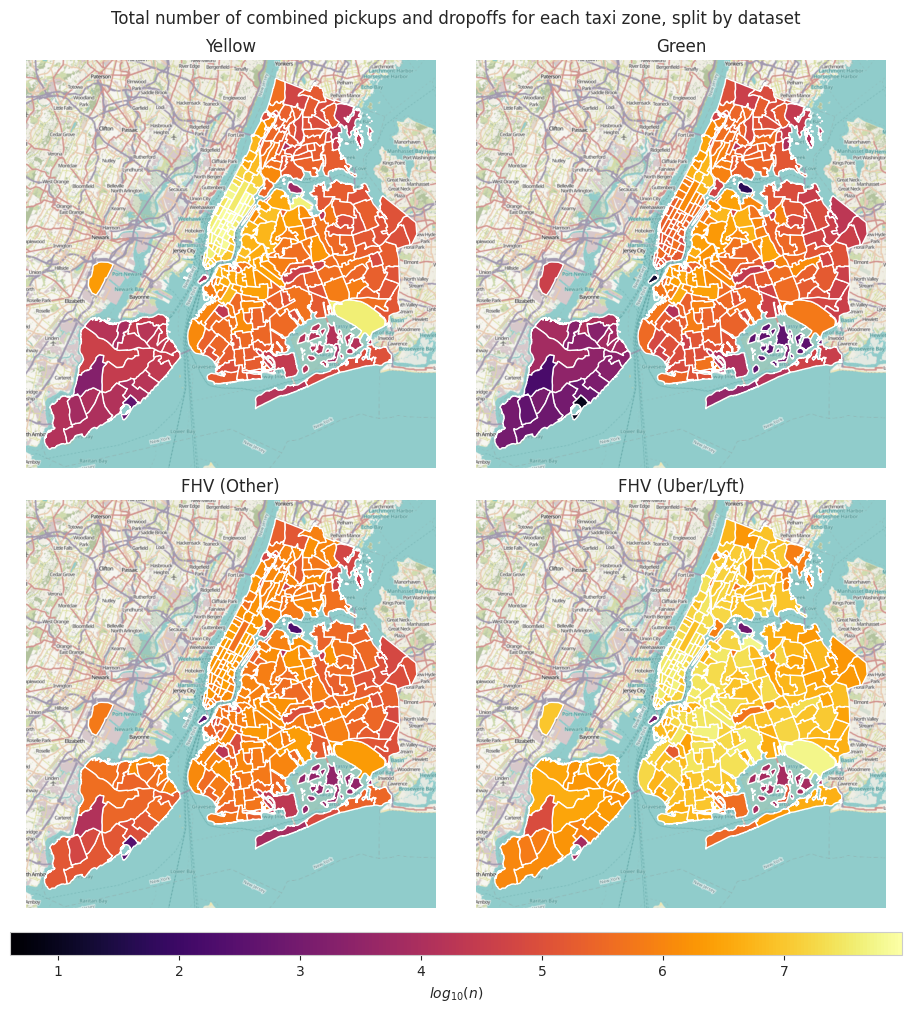

In [13]:
vmin = np.log10(df_volume_over_zones["n"]).min()
vmax = np.log10(df_volume_over_zones["n"]).max()
norm = plt.Normalize(vmin, vmax)
cmap = "inferno"


def plot_volume_singleax(df: pd.DataFrame, ax):
    gdf_merged = gdf_shapefile.to_crs(epsg=3857).merge(
        df.assign(n=lambda df: np.log10(df["n"])),
        how="right",
        left_on="OBJECTID",
        right_on="locid",
    )
    gdf_merged.plot(
        ax=ax,
        column="n",
        cmap=cmap,
        norm=norm,
    )
    contextily.add_basemap(ax, attribution=False)
    ax.axis("off")


fig, axs = plt.subplots(2, 2, figsize=(9, 10), layout="constrained")
((ax1, ax2), (ax3, ax4)) = axs

plot_volume_singleax(df_volume_over_zones.loc[lambda df: df["label"] == "yellow"], ax1)
ax1.set_title("Yellow")

plot_volume_singleax(df_volume_over_zones.loc[lambda df: df["label"] == "green"], ax2)
ax2.set_title("Green")

plot_volume_singleax(
    df_volume_over_zones.loc[lambda df: df["label"] == "fhv_small"], ax3
)
ax3.set_title("FHV (Other)")

plot_volume_singleax(df_volume_over_zones.loc[lambda df: df["label"] == "fhv_big"], ax4)
ax4.set_title("FHV (Uber/Lyft)")

fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=axs,
    orientation="horizontal",
    aspect=40,
    pad=0.025,
).set_label("$log_{10}(n)$")

fig.set_constrained_layout_pads(h_pad=0.05)
fig.suptitle(
    "Total number of combined pickups and dropoffs for each taxi zone, split by dataset"
)

savefig(fig, "fig/t4_volume_zones.pdf")

## Volume over arcs


In [14]:
df_volume_over_arcs = (
    dd.concat([ddf_yellow, ddf_green, ddf_fhv, ddf_fhvhv])
    .groupby(["pu_locid", "do_locid"])
    .agg(n=("pu_locid", "size"))
    .reset_index()
    .compute()
    .sort_values("n", ascending=False, ignore_index=True)
)
(
    df_volume_over_arcs.merge(
        gdf_shapefile[["OBJECTID", "zone", "borough"]].rename(
            columns={"zone": "pu_zone", "borough": "pu_borough"}
        ),
        how="left",
        left_on="pu_locid",
        right_on="OBJECTID",
    )
    .drop(columns="OBJECTID")
    .merge(
        gdf_shapefile[["OBJECTID", "zone", "borough"]].rename(
            columns={"zone": "do_zone", "borough": "do_borough"}
        ),
        how="left",
        left_on="do_locid",
        right_on="OBJECTID",
    )
    .drop(columns="OBJECTID")
)

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


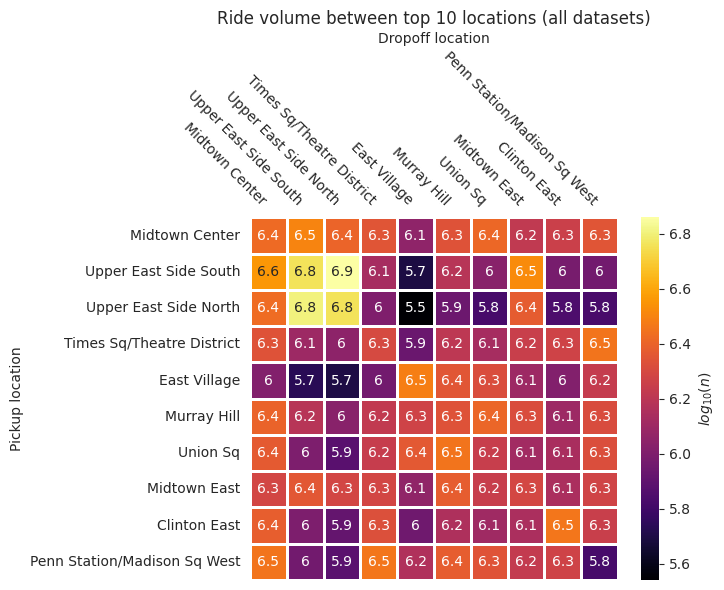

In [15]:
top_locids = list(
    df_volume_over_arcs.melt(id_vars=["n"], value_name="locid")[["n", "locid"]]
    .astype({"locid": "int32"})
    .groupby("locid")
    .sum()
    .reset_index()
    .sort_values("n", ascending=False, ignore_index=True)["locid"]
    .head(10)
)

top_locids_names = list(
    pd.Series(top_locids)
    .to_frame("OBJECTID")
    .merge(gdf_shapefile[["OBJECTID", "zone", "borough"]], how="left")
    .pipe(disp)["zone"]
)

matrix = (
    df_volume_over_arcs.loc[
        lambda df: df["pu_locid"].isin(top_locids) & df["do_locid"].isin(top_locids)
    ]
    .pivot_table(index="pu_locid", columns="do_locid", values="n")
    .reindex(index=top_locids, columns=top_locids)
    .set_axis(top_locids_names, axis=0)
    .set_axis(top_locids_names, axis=1)
)

fig, ax = plt.subplots(figsize=(7.3, 6))

sns.heatmap(
    np.log10(matrix),
    ax=ax,
    cmap="inferno",
    annot=True,
    linewidth=1,
    cbar_kws={"label": "$log_{10}(n)$"},
)

ax.set_title("Ride volume between top 10 locations (all datasets)")
ax.set_xlabel("Dropoff location")
ax.set_ylabel("Pickup location")

ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params("x", top=False)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=-45, ha="right")

fig.tight_layout()
savefig(fig, "fig/t4_volume_arcs.pdf")

## Average fare over taxi zones


In [16]:
df_fare_over_zones = (
    dd.concat(
        [ddf[["pu_locid", "fee_fare"]] for ddf in (ddf_yellow, ddf_green, ddf_fhvhv)]
    )
    .groupby("pu_locid")
    .agg(fare_mean=("fee_fare", "mean"))
    .reset_index()
    .compute()
    .sort_values("fare_mean", ascending=False, ignore_index=True)
)
df_fare_over_zones.merge(
    gdf_shapefile[["OBJECTID", "zone", "borough"]],
    how="left",
    left_on="pu_locid",
    right_on="OBJECTID",
).drop(columns="OBJECTID")

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


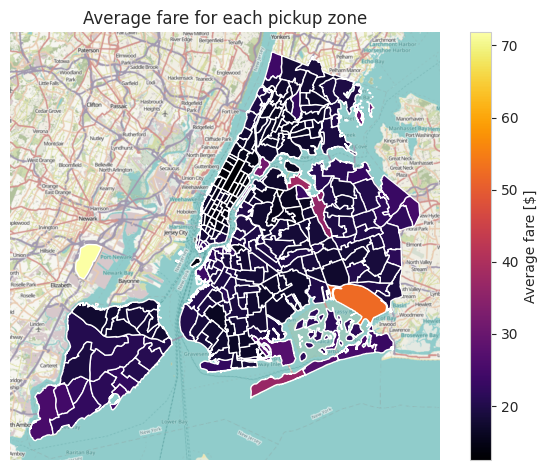

In [17]:
fig, ax = plt.subplots()

gdf_merged = gdf_shapefile.to_crs(epsg=3857).merge(
    df_fare_over_zones,
    how="right",
    left_on="OBJECTID",
    right_on="pu_locid",
)
gdf_merged.plot(
    ax=ax,
    column="fare_mean",
    cmap="inferno",
    legend=True,
    legend_kwds={"label": "Average fare [$]"},
)
contextily.add_basemap(ax, attribution=False)
ax.axis("off")

ax.set_title("Average fare for each pickup zone")

fig.tight_layout()
savefig(fig, "fig/t4_fares_zones.pdf")

## Payment types


In [18]:
df_payment_types = (
    dd.concat([ddf_yellow.assign(label="yellow"), ddf_green.assign(label="green")])
    .assign(payment_type=lambda ddf: ddf["payment_type"].fillna(5))
    .groupby(["label", "payment_type"])
    .agg(n=("label", "size"))
    .reset_index()
    .compute()
    .sort_values(["payment_type", "label"], ignore_index=True)
)
df_payment_types

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


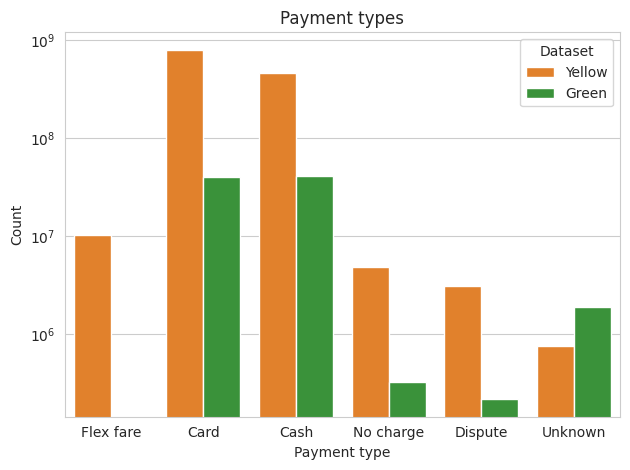

In [19]:
fig, ax = plt.subplots()

sns.barplot(
    df_payment_types.assign(
        Dataset=lambda df: df["label"].str.capitalize(),
        payment_type=lambda df: df["payment_type"].map(
            {
                0: "Flex fare",
                1: "Card",
                2: "Cash",
                3: "No charge",
                4: "Dispute",
                5: "Unknown",
                6: "Voided trip",
            }
        ),
    ),
    ax=ax,
    x="payment_type",
    y="n",
    hue="Dataset",
    palette=LABEL_HUMAN_READABLE_TO_COLOR,
)

ax.set_yscale("log")

ax.set_title("Payment types")
ax.set_xlabel("Payment type")
ax.set_ylabel("Count")

fig.tight_layout()
savefig(fig, "fig/t4_payment_types.pdf")

## Trip times

Requires "FHV/FHVHV operator mapping"


In [28]:
bin_width = 10
df_trip_times = (
    dd.concat(
        [
            ddf_yellow.assign(label="yellow"),
            ddf_green.assign(label="green"),
            ddf_fhv.pipe(classify_fhv),
            ddf_fhvhv.pipe(classify_fhvhv),
        ]
    )
    .assign(
        time=lambda ddf: (
            (ddf["do_dt"] - ddf["pu_dt"])
            .dt.total_seconds()
            .map_partitions(
                pd.cut,
                bins=[
                    0,
                    60,
                    300,
                    600,
                    1800,
                    3600,
                    10800,
                    21600,
                    43200,
                    64800,
                    86400,
                    np.inf,
                ],
                labels=[
                    "0-60s",
                    "1-5min",
                    "5-10min",
                    "10-30min",
                    "30-60min",
                    "1-3h",
                    "3-6h",
                    "6-12h",
                    "12-18h",
                    "18-24h",
                    "24h+",
                ],
            )
        )
    )
    .groupby(["label", "time"], observed=True)
    .agg(n=("time", "size"))
    .reset_index()
    .compute()
    .sort_values(["time", "label"], ignore_index=True)
)
df_trip_times

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


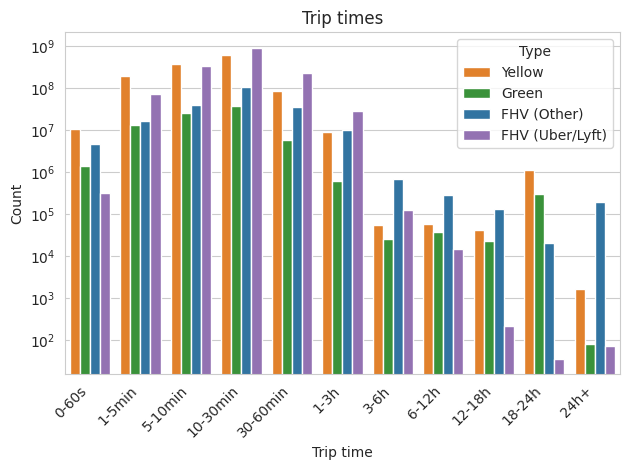

In [29]:
fig, ax = plt.subplots()

sns.barplot(
    df_trip_times.assign(Type=lambda df: df["label"].pipe(label_to_human_readable)),
    ax=ax,
    x="time",
    y="n",
    hue="Type",
    palette=LABEL_HUMAN_READABLE_TO_COLOR,
)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yscale("log")

ax.set_title("Trip times")
ax.set_xlabel("Trip time")
ax.set_ylabel("Count")

fig.tight_layout()
savefig(fig, "fig/t4_trip_times.pdf")

## Trip distance vs fares


In [30]:
df_trip_distance_vs_fares = (
    dd.concat([ddf_yellow, ddf_green, ddf_fhvhv])
    .assign(distance=lambda ddf: np.floor(np.log10(ddf["distance"]) * 100))
    .groupby("distance")
    .agg(
        fare=("fee_fare", "mean"),
        n=("distance", "size"),
    )
    .reset_index()
    .assign(distance=lambda ddf: 10 ** (ddf["distance"] / 100))
    .compute()
    .sort_values("distance", ignore_index=True)
)
df_trip_distance_vs_fares

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


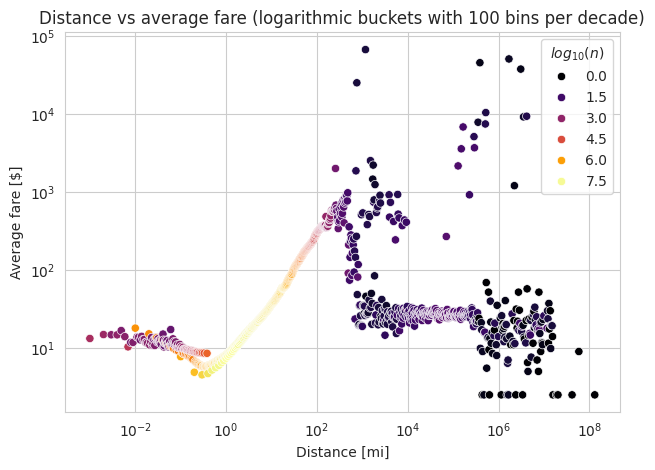

In [31]:
fig, ax = plt.subplots()

ax = sns.scatterplot(
    df_trip_distance_vs_fares.assign(**{"$log_{10}(n)$": lambda df: np.log10(df["n"])}),
    ax=ax,
    x="distance",
    y="fare",
    hue="$log_{10}(n)$",
    palette="inferno",
)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_title("Distance vs average fare (logarithmic buckets with 100 bins per decade)")
ax.set_xlabel("Distance [mi]")
ax.set_ylabel("Average fare [$]")

fig.tight_layout()
savefig(fig, "fig/t4_distance_vs_fares.pdf")

## Fare vs tips

Requires "FHV/FHVHV operator mapping"


In [32]:
src = (
    dd.concat(
        [
            ddf_yellow.assign(label="yellow"),
            ddf_green.assign(label="green"),
            ddf_fhvhv.pipe(classify_fhvhv),
        ]
    )[["label", "fee_fare", "fee_tip"]]
    .dropna()
    .loc[lambda ddf: ddf["fee_fare"] < 1000]
    .assign(fare=lambda ddf: (ddf["fee_fare"] // 10) * 10 + 5)
)

outlier_thresholds = (
    src.groupby(["label", "fare"])
    .agg(tip_max=("fee_tip", agg_tdigest(quantile=0.95)))
    .reset_index()
    .compute()
)

df_fare_vs_tips = (
    src.merge(outlier_thresholds, how="left", on=["label", "fare"])
    .loc[lambda ddf: ddf["fee_tip"] < ddf["tip_max"]]
    .groupby(["label", "fare"])
    .agg(
        tip=("fee_tip", "mean"),
        n=("fare", "size"),
    )
    .reset_index()
    .compute()
    .sort_values(["fare", "label"], ignore_index=True)
)
df_fare_vs_tips

/d/hpc/home/mp4116/project/.venv/lib/python3.13/site-packages/dask/dataframe/multi.py:169: UserWarning: Merging dataframes with merge column data type mismatches: 
+--------------------+------------+-------------+
| Merge columns      | left dtype | right dtype |
+--------------------+------------+-------------+
| ('label', 'label') | object     | string      |
+--------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


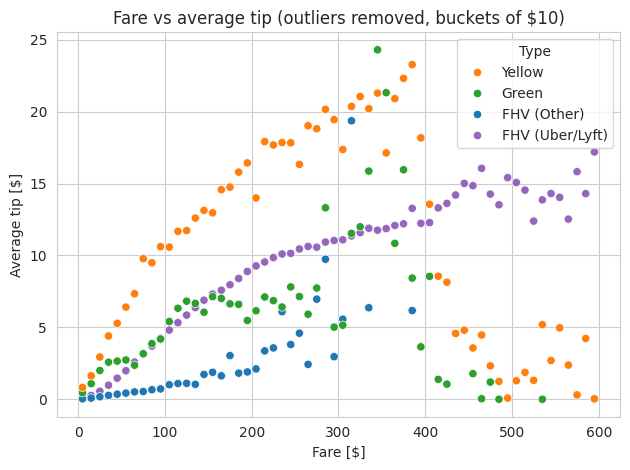

In [33]:
fig, ax = plt.subplots()

sns.scatterplot(
    df_fare_vs_tips.loc[lambda df: (df["n"] > 10) & (df["fare"] < 600)].assign(
        Type=lambda df: df["label"].pipe(label_to_human_readable)
    ),
    ax=ax,
    x="fare",
    y="tip",
    hue="Type",
    palette=LABEL_HUMAN_READABLE_TO_COLOR,
)

ax.set_title("Fare vs average tip (outliers removed, buckets of $10)")
ax.set_xlabel("Fare [$]")
ax.set_ylabel("Average tip [$]")

fig.tight_layout()
savefig(fig, "fig/t4_fare_vs_tips.pdf")

# Task 8


## Relative

Requires EDA/"Volume over time (monthly)"


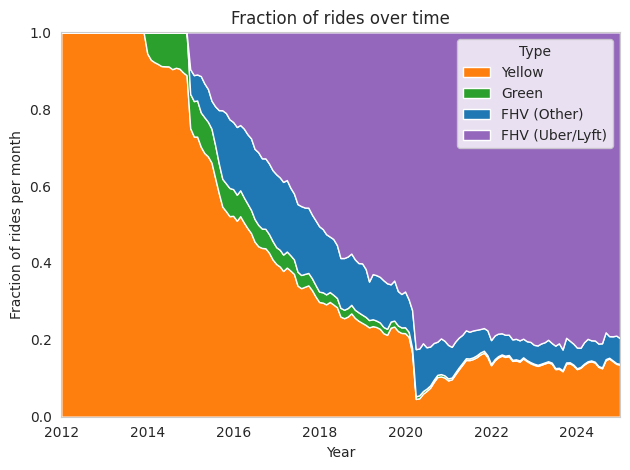

In [34]:
df = (
    df_volume_over_time_month.pivot(
        columns="label",
        index="month",
        values="volume",
    )
    .fillna(0)
    .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
)

fig, ax = plt.subplots()
line = ax.stackplot(
    df.index.to_timestamp(),
    [df["yellow"], df["green"], df["fhv_small"], df["fhv_big"]],
    labels=["Yellow", "Green", "FHV (Other)", "FHV (Uber/Lyft)"],
    colors=[
        COLOR_YELLOW,
        COLOR_GREEN,
        COLOR_FHV,
        COLOR_FHVHV,
    ],
)

ax.margins(0, 0)

ax.set_title("Fraction of rides over time")
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of rides per month")

ax.legend(title="Type")
fig.tight_layout()
savefig(fig, "fig/t8_relative.pdf")